In [116]:
# Load libraries.
import pandas as pd
import numpy as np

# Visualisation libraries.
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer # You will need the scikit-learn version >= 0.22
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [117]:
# Load the dataset
df = pd.read_csv('UsArrests.csv')
df.set_index('City', inplace=True)
display(df.head())

# Display the shape
display(df.shape)

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


(50, 4)

Murder      float64
Assault       int64
UrbanPop      int64
Rape        float64
dtype: object

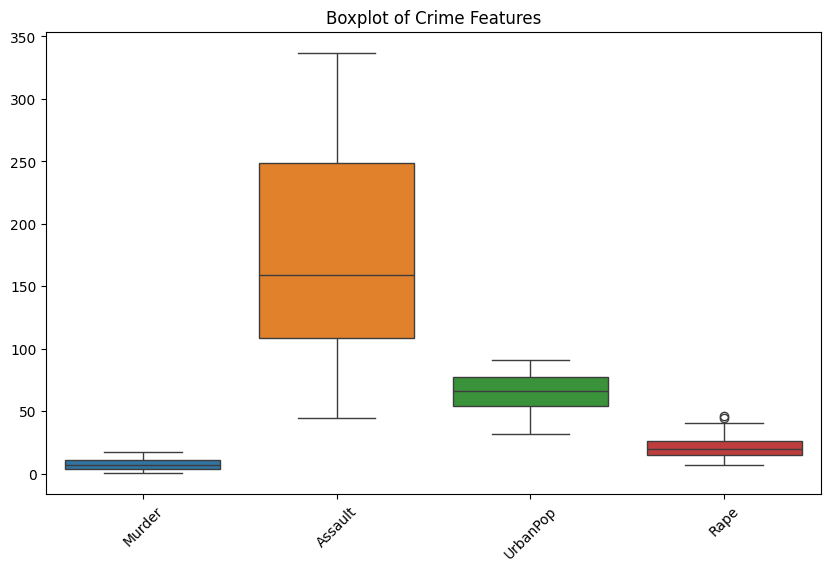

In [118]:
# Display data types
display(df.dtypes)

# Check for outliers using boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot of Crime Features')
plt.xticks(rotation=45)
plt.show()


From the boxplot, the Assault feature has the highest variability and therefore the highest potential to influence the clustering, therefore it must be standardized. Murder has the lowest variability across the states. UrbanPop is evenly distributed across the states and there are no extreme values. The Rape feature has outliers, showing that some states report significantly higher rape incidences than others.

In [119]:
# Check for missing values
display(df.isnull().sum())


Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [120]:
# Display summary statistics
display(df.describe())

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


From the summary of the statistics, containes 50 US states. The average Murder rate is 7.79, the Assault rate is 170.76, the UrbanPop is 65.54% and the Rape rate is 21.23.

Assault has the highest standard deviation of 83.33, once again proving that it has the highest variability. The maximum and minimum values higlight the range in crime rates. Murder ranges from 0.80 to 17.40, Assault ranges from 45.00 to 337.00, UrbanPop from 32.00 to 91.00 and Rape from 7.30 to 46.00

### Correlation Analysis

<Axes: >

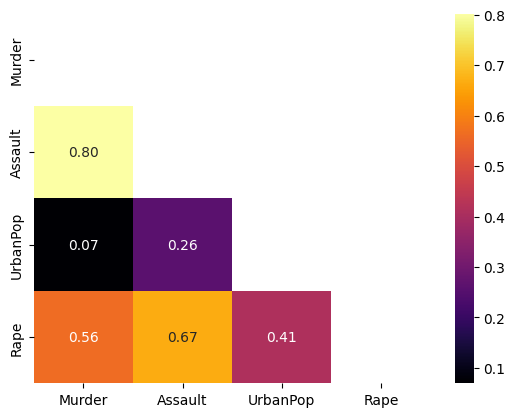

In [121]:
corr_df = df.corr()
labels = corr_df.columns

# Plot heatmap
mask_ut = np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap='inferno', annot=True, fmt='.2f')

From the correlation analysis, the strongest positive correlation is between Assault and Murder at 0.80. Assault and Rape also have a strong positive correlation of 0.67. There is a moderate correlation between Murder and Rape at 0.56. The weaker correlations are between UrbanPop and Rape at 0.41, Assault and UrbanPop at 0.26 and the weakest correlation is between UrbanPop and murder at 0.07.

Due to Murder, Assault and Rape are all positively correlated, suggesting that they have related underlying factors. The UrbanPop feature has a weaker relationship with other crime features indicating that more ubranized areas may not always correlate with higher crime levels.

In [122]:
# Standardise
X_std = StandardScaler().fit_transform(df)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans, index=df.index)
df_std_pca.head()

,0,1,2,3
City,,,,
Alabama,0.985566,-1.133392,-0.444269,-0.156267
Alaska,1.950138,-1.073213,2.040003,0.438583
Arizona,1.763164,0.745957,0.054781,0.834653
Arkansas,-0.141420,-1.119797,0.114574,0.182811
California,2.523980,1.542934,0.598557,0.341996


### Selecting number of principal components

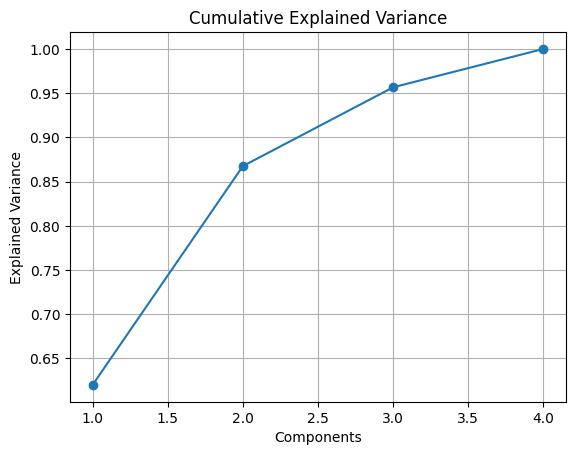

In [123]:
# Explain the variance using a cumulative variance plot
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.plot(range(1, len(std_pca.explained_variance_ratio_)+1),
         np.cumsum(std_pca.explained_variance_ratio_), 
         marker='o',
)
plt.title('Cumulative Explained Variance')
plt.grid(True)

From the cumulative explained variance plot, the first principal component explains around 62% of the variance. A combination of the first two principal components explains around 87% of the variance. The first three components explain around 96% of the variance and a combination of all four components explains 100% of the data.

In [124]:
print(np.cumsum(std_pca.explained_variance_ratio_))

[0.62006039 0.86750168 0.95664248 1.        ]


The first 2 principal components will be selected for further analysis (PC1 and PC2). PC1 accounts for approximately 62% of the total variance. PC2 accounts for approximately 25% of the total variance. Therefore, together, PC1 and PC2 account for around 87% of the total variance. Together, PC3 and PC4 only contribute around 13% of the total variance.

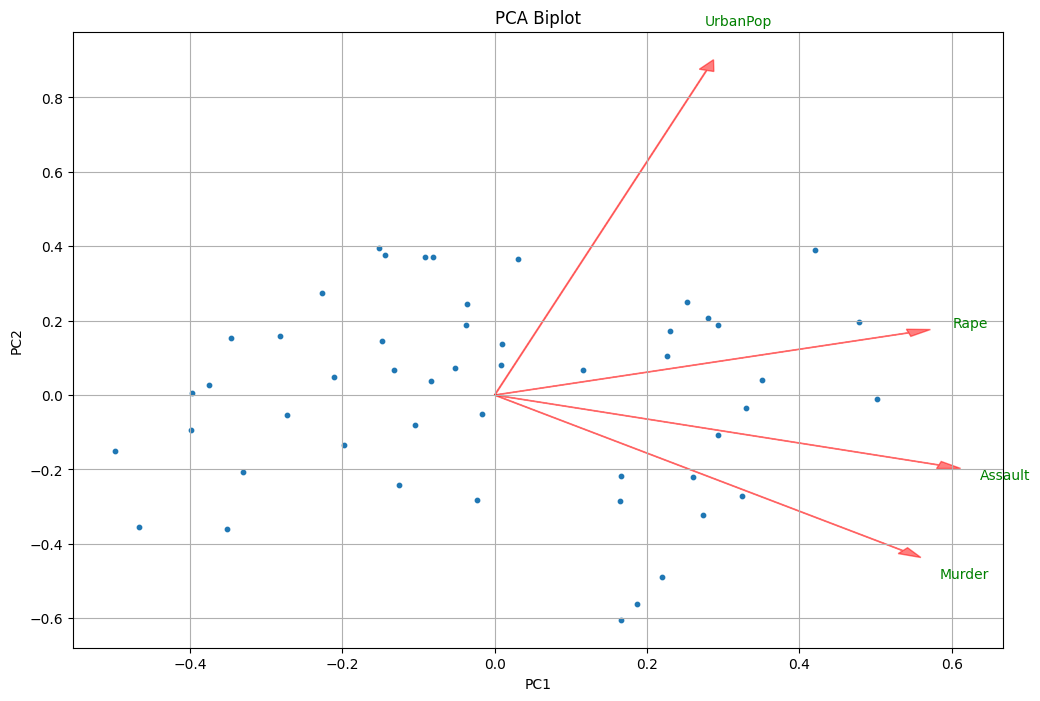

In [125]:
# Create biplot function
def biplot(score, coeff, labels=None, points_labels=None):
    """
    score:
    coeff:
    labels:
    points_labels:
    """
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]

    scalex = 1.0/ (xs.max() - xs.min())
    scaley = 1.0/ (ys.max() - ys.min())

    fig, ax = plt.subplots(figsize=(12,8))

    # Plot the points
    if points_labels is not None:
        unique_labels = np.unique(points_labels)
        colors = ['red', 'green', 'blue']
        
        for ul, color in zip(unique_labels, colors):
            subset_xs = xs[points_labels == ul]
            subset_ys = ys[points_labels == ul]
            ax.scatter(subset_xs * scalex, subset_ys * scaley, label=ul, s=50)
        ax.legend()

    else:
        ax.scatter(xs * scalex, ys * scaley, s=10)
    
    # Plot arrows for features
    for i in range(n):
        ax.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5, head_width=0.02)
        
        if labels is None:
            ax.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, "Var"+str(i+1),
                    color='g', ha='center', va='center')
            
        else:
            ax.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, labels[i],
                    color='g', ha='center', va='center')
            
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Biplot')
    plt.grid(True)
    plt.show()

# Call the biplot function
biplot(score=X_std_trans, coeff=std_pca.components_.T, labels=X.columns)


From the biplot, UrbanPop, Assauly, Murder and Rape have long arrows therefore indicating a strong contribution to the principal components. Rape, Assault and Murder point in similar directions therefore indicating a strong positive contribution to PC1. UrbanPop has the strongest correlation to Rape and the weakest correlation to Murder. 

### Hierarchical Clustering

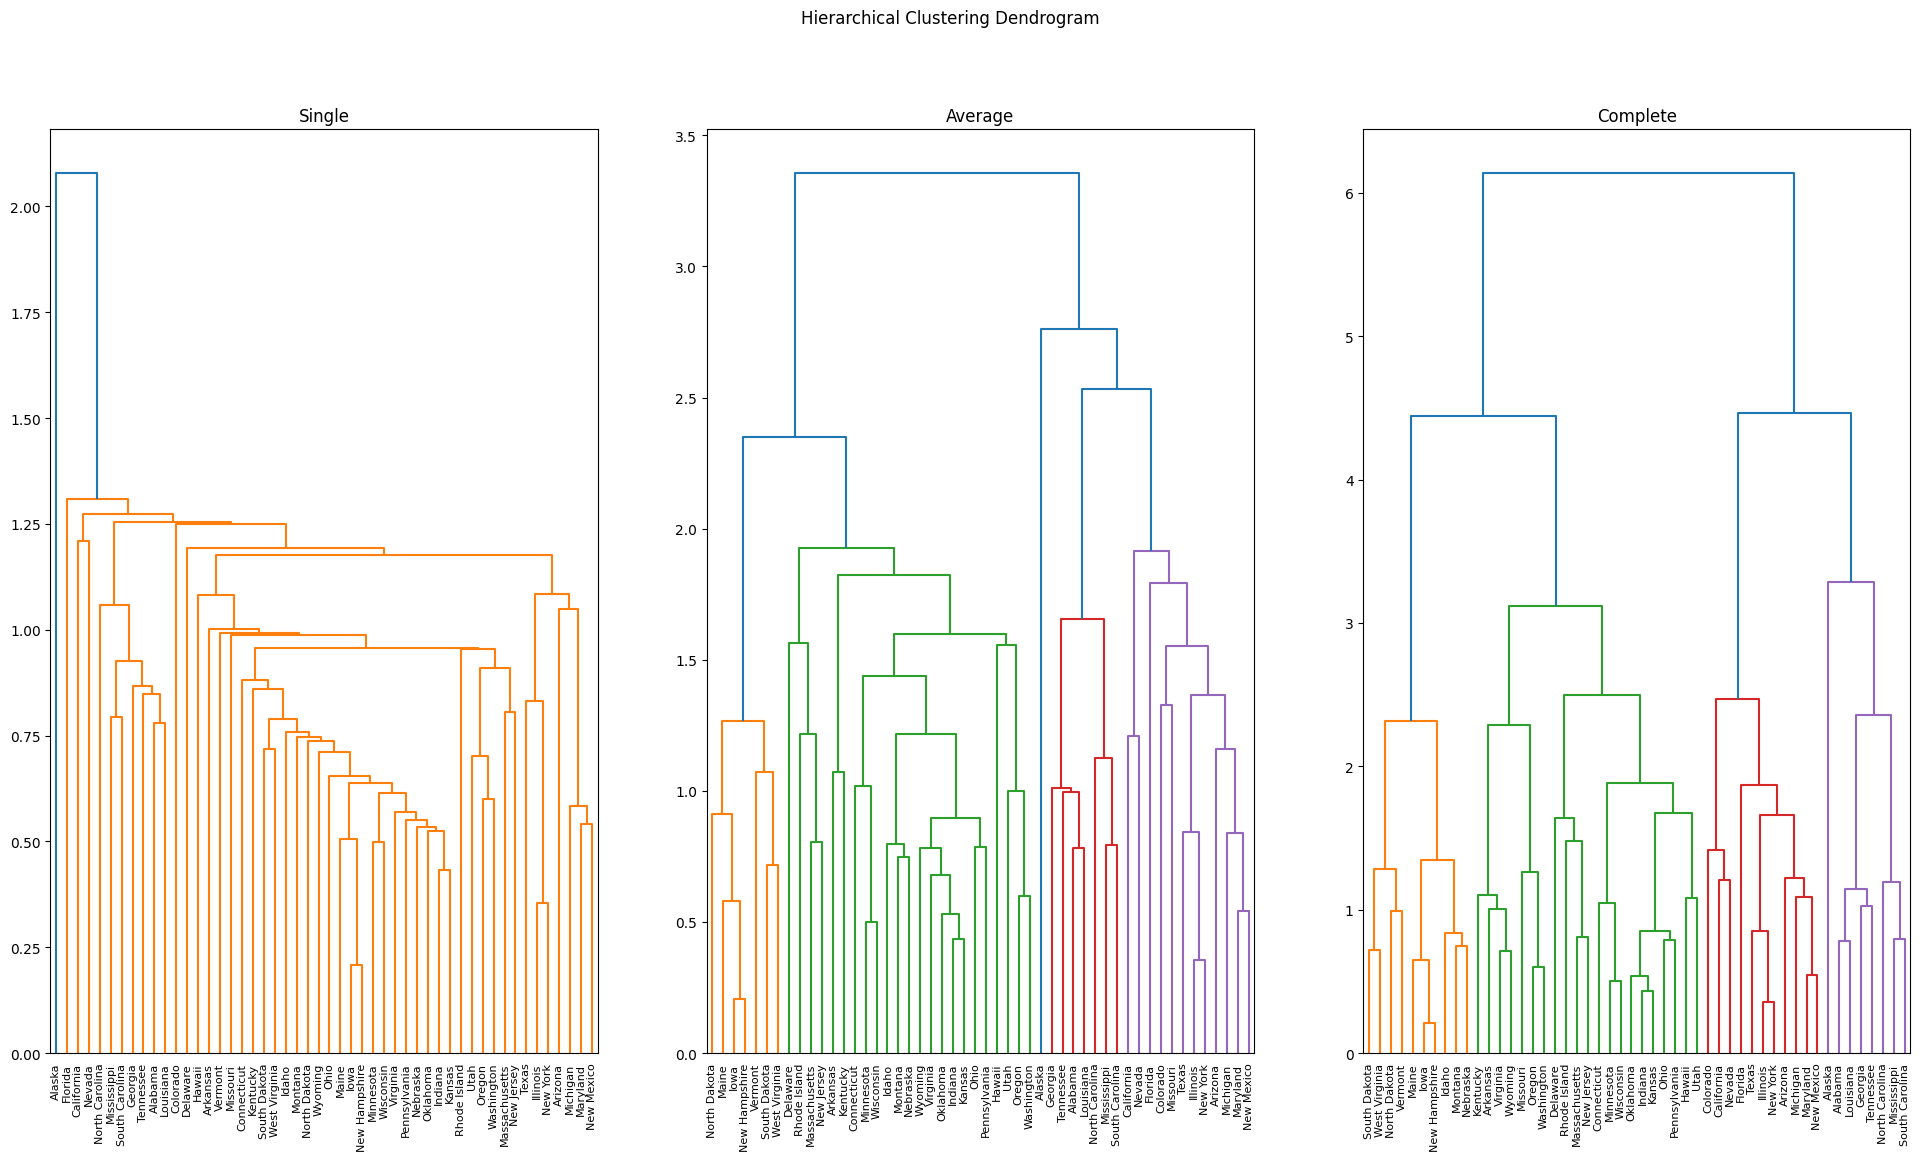

In [126]:
# Cluster data and plot dendrogram
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(df_std_pca)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))
fig.suptitle('Hierarchical Clustering Dendrogram')

ax1.set_title('Single')
dendrogram(linkage(df_std_pca, method='single'), labels=df_std_pca.index, ax=ax1)

ax2.set_title('Average')
dendrogram(linkage(df_std_pca, method='average'), labels=df_std_pca.index, ax=ax2)

ax3.set_title('Complete')
dendrogram(linkage(df_std_pca, method='complete'), labels=df_std_pca.index, ax=ax3)

plt.show()

In [127]:
# Calculate the silhouette scores for different methods
linkage_methods = ['single', 'average', 'complete']

for method in linkage_methods:
    model = AgglomerativeClustering(n_clusters=3, linkage=method)
    labels = model.fit_predict(df_std_pca)

    # Calculate the silhouette score
    score = silhouette_score(df_std_pca, labels)
    print(f"{method.capitalize()} Linkage - Silhouette Score: {score: .3f}")

Single Linkage - Silhouette Score:  0.146
Average Linkage - Silhouette Score:  0.349
Complete Linkage - Silhouette Score:  0.369


From the Silhouette Scores, the complete linkage methos produced the best cluster seperation (0.369) and therefore complete linkage is the model that will be chosen.

### K-means Clustering

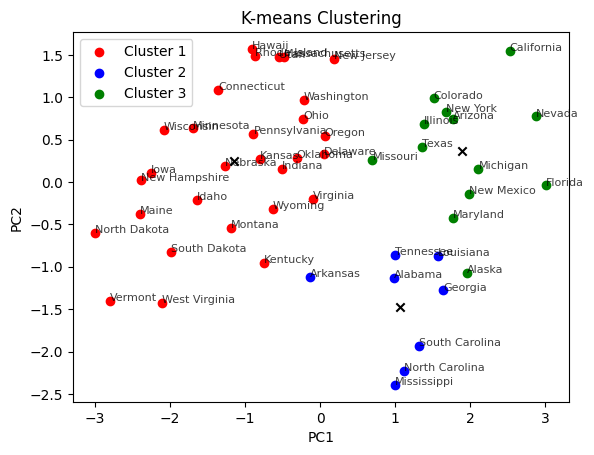

In [128]:
# Extract the first 2 components
x = X_std_trans[:, 0]
y = X_std_trans[:, 1]

# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(df_std_pca)

# cluster_labels = kmeans.fit_predict(X_std_trans[:, :2])
centers = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0, k):
    ax.scatter(x[cluster_labels == i], 
               y[cluster_labels == i], 
               c=colours[i],
               label=f'Cluster {i+1}'
    )

# Plot centroids
ax.scatter(
    centers[: , 0], 
    centers[: ,1], 
    c='black', 
    marker='x',
)

# Annotate each point
for i, city in enumerate(df_std_pca.index):
    ax.annotate(city, (x[i], y[i]), fontsize=8, alpha=0.75)

ax.set_title('K-means Clustering')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

The two clustering methods selected were hierarchial clustering and K-means clustering. 

Dendrograms were plotted using Single, Average and Complete linkage methods. However, the Complete linkage method resulted on the highest silhouette score (0.369). From this we can infer that the Complete linkage method has the best defined and well seperated clusters. From the dendrograms it is visible that the states with similar patterns in crime, cluster together.

K-means clustering was conducting using the first two principal components, with three clusters. The clusters that were generated are consistent with that of the hierachial clustering. The K-means clustering method grouped states into three clusters.

When comparing hierarchial and K-means clustering, the following patterns are reflected:
- Cluster 1: States in the red cluster, have higher rates of violent crimes such as murfer, assault and rape. 
- Cluster 2: States in the blue cluster, have a lower overall crime rate. This may be due to the states having better law enforcement or better socio-economic stability. The states in this group show similarities in urbanisation however they have a lower level of violent crimes compared to Cluster 1.
- Cluster 3: States in the green, have moderate crime levels. States in this cluser have greater urbanisation and population density.

In conclusion, states within the same cluster have similar crime profiles. When observing where the clustered states are geographically located in the U.S.A, we find that states in cluster 1 are generally in the midwestern and nothern regions, states in cluster 2 are generally located in the southern regiona and states in cluster 3 are generally in the western region. From this we can infer that trends in crime in America can be grouped regionally. 
